<a href="https://colab.research.google.com/github/pran872/Brain-Network/blob/main/level3_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
from torch.nn import MaxPool2d, functional as F
from torch import cat

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.9 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(full_train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Flex2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device, stride=1, padding=0, config=None):
        super().__init__()
        """
        # in dimensions: in this case [C, H, W]
        # --------
        # logits_mechanism: THRESHOLD or SPATIAL_ATTENTION_(1-3)
        # masking_mechanism: "SIGMOID", "STE", "SIGMOID_SMOOTHED", "STE_SIGMOID"
        # num_spatial_attention_block: int
        # logits_use_batchnorm: bool

        # about parameter vs variable:
        variable is almost deprecated and works the same as just plain tensor. And a Parameters is a specific Tensor that is marked as being a parameter from an nn.Module and so will be returned when calling .parameters() on this Module.
        """
        # -------- set configs --------
        # assert config, "Missing config file for Flex2D"
        # self.config = config
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.device = device

        # -------- Initialize layers --------
        self.flex_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.flex_pool = MaxPool2d(kernel_size, stride, padding)
        self.bn_logits = nn.BatchNorm2d(self.out_channels)

        # -------- Initialize monitored variables --------
        self.homogeneity = 0  # for monitoring the binariness of the mask later on
        self.conv_ratio = 0  # for later updating
        self.cp_identity_matrix = None  # store the matrix indicating the channel pool identity

    def channel_interpolate(self, tensor, out_channels):
        """
        Interpolates a tensor along the channel axis. This is for addressing the mismatch in the number of channels between the output of the maxpool layer and the output of the convolutional layer.
        """
        tensor = tensor.permute(0, 2, 1, 3)
        tensor = F.interpolate(tensor, [out_channels, tensor.size(3)], mode="bilinear")
        tensor = tensor.permute(0, 2, 1, 3)
        return tensor

    def channel_wise_maxpool(self, tensor_1, tensor_2):
        """
        Take two tensors of identical shape and return a tensor of the same shape using element-wise max pooling.
        Also returns the ratio of values from tensor_2 to the total.
        """
        assert tensor_1.shape == tensor_2.shape, "tensor_1 and tensor_2 must have the same shape"

        joint = cat([tensor_1.unsqueeze(-1), tensor_2.unsqueeze(-1)], dim=-1)
        pooled, indices = torch.max(joint, dim=-1)

        # count values are from conv (tensor 2)
        with torch.no_grad():
            conv_ratio = (indices == 1).sum().item() / tensor_1.numel()
            cp_identity_matrix = (indices == 1).int()

        return pooled, conv_ratio, cp_identity_matrix

    def forward(self, x):
        """
        threshold can only be initialized when the output dimensions are known
        """
        # -------- make the raw conv and pool --------
        print("Input to self.flex_pool:", x.size())
        t_flex_pool = self.flex_pool(x)
        print("Output of t_flex_pool:", t_flex_pool.size())
        t_flex_conv = self.flex_conv(x)
        print("Output of t_flex_conv:", t_flex_conv.size())
        t_flex_pool = self.channel_interpolate(t_flex_pool, self.out_channels)
        print("Output of chhannel interpolate:", t_flex_pool.size(), "Self out channels:", self.out_channels)

        # -------- get the binary mask --------
        output, self.conv_ratio, self.cp_identity_matrix = self.channel_wise_maxpool(t_flex_pool, t_flex_conv)
        print("Output of chhannel wise maxpool:", output.size())
        print("\nConv ratio:", self.conv_ratio, "\n")
        return output

In [4]:
class CustomViTHybrid(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3,
                 cnn_channels=32, embed_dim=64, depth=2, heads=4,
                 num_classes=10, use_flex=False, device="cpu"):
        super().__init__()

        self.use_flex = use_flex
        self.device = device

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 32 → 16

        # Optional second layer: Flex2D or Conv
        if self.use_flex:
            self.flex = Flex2D(16, cnn_channels, kernel_size=3, stride=1, padding=1, device=self.device)
        else:
            self.conv2 = nn.Conv2d(16, cnn_channels, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 16 → 8

        # Patch embedding
        self.patch_embed = nn.Conv2d(cnn_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (8 // patch_size) ** 2

        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # ViT encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        print("Input to model:", x.size(), "Batch size", B)
        print("Output of first conv layer: ", self.conv1(x).size())
        x = F.relu(self.conv1(x))
        print("Output of relu on first conv layer: ", x.size())
        x = self.pool1(x)
        print("Output of first pooling: ", x.size())

        if self.use_flex:
            x = self.flex(x)
            print("Output of flex layer conv: ", x.size())
        else:
            x = F.relu(self.conv2(x))
            print("Output of conv layer no flex: ", x.size())
        x = self.pool2(x)
        print("Output of second pool: ", x.size())

        x = self.patch_embed(x)                      # [B, embed_dim, H', W']
        x = x.flatten(2).transpose(1, 2)             # [B, num_patches, embed_dim]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        x = self.transformer(x)
        x = x[:, 0]  # Use CLS token
        return self.mlp_head(x)


In [5]:
model = CustomViTHybrid(use_flex=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [6]:
def train_model(epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)
        print(f"Epoch {epoch+1}: Train Acc={train_accuracies[-1]:.2f}% | Val Acc={val_accuracies[-1]:.2f}%")


In [7]:
def test_model():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

train_model(epochs=1)
test_model()


Epoch 1 [Train]:   1%|          | 1/176 [00:03<10:33,  3.62s/it]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.13170623779296875 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])


Epoch 1 [Train]:   1%|          | 2/176 [00:03<04:33,  1.57s/it]

Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.13509559631347656 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel in

Epoch 1 [Train]:   2%|▏         | 4/176 [00:04<01:43,  1.65it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12899017333984375 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])


Epoch 1 [Train]:   3%|▎         | 5/176 [00:04<01:23,  2.05it/s]

Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12688875198364258 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256


Epoch 1 [Train]:   3%|▎         | 6/176 [00:04<01:04,  2.62it/s]

Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12340259552001953 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_fle

Epoch 1 [Train]:   4%|▍         | 7/176 [00:04<00:51,  3.30it/s]

Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12325239181518555 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12095069885253906 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])


Epoch 1 [Train]:   5%|▌         | 9/176 [00:04<00:34,  4.78it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.12344741821289062 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:   6%|▋         | 11/176 [00:05<00:27,  6.00it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.114776611328125 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of 

Epoch 1 [Train]:   7%|▋         | 13/176 [00:05<00:26,  6.10it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.11182737350463867 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:   8%|▊         | 14/176 [00:05<00:27,  5.91it/s]

Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10926675796508789 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10917520523071289 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])


Epoch 1 [Train]:   9%|▉         | 16/176 [00:05<00:23,  6.76it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10396289825439453 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  10%|█         | 18/176 [00:06<00:21,  7.40it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10056114196777344 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  11%|█         | 19/176 [00:06<00:23,  6.82it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09064674377441406 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])


Epoch 1 [Train]:  12%|█▏        | 21/176 [00:06<00:26,  5.83it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09015417098999023 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  12%|█▎        | 22/176 [00:06<00:26,  5.73it/s]

Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09288740158081055 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09047079086303711 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of se

Epoch 1 [Train]:  14%|█▎        | 24/176 [00:07<00:23,  6.54it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08856868743896484 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  15%|█▍        | 26/176 [00:07<00:21,  6.98it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08833980560302734 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  16%|█▌        | 28/176 [00:07<00:20,  7.12it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0899343490600586 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  17%|█▋        | 30/176 [00:07<00:19,  7.44it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09227466583251953 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  18%|█▊        | 32/176 [00:08<00:18,  7.69it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09853792190551758 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  19%|█▉        | 34/176 [00:08<00:18,  7.67it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10338449478149414 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  20%|██        | 36/176 [00:08<00:18,  7.76it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10539484024047852 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  22%|██▏       | 38/176 [00:08<00:17,  7.92it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.11118555068969727 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  23%|██▎       | 40/176 [00:09<00:17,  7.91it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10998058319091797 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  24%|██▍       | 42/176 [00:09<00:17,  7.86it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.11209869384765625 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  25%|██▌       | 44/176 [00:09<00:18,  7.12it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10512447357177734 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  26%|██▌       | 46/176 [00:10<00:17,  7.24it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.10157299041748047 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  27%|██▋       | 48/176 [00:10<00:17,  7.40it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09649229049682617 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  28%|██▊       | 50/176 [00:10<00:16,  7.49it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.09630680084228516 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  30%|██▉       | 52/176 [00:10<00:16,  7.74it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0913686752319336 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  31%|███       | 54/176 [00:11<00:15,  7.90it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0871591567993164 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  32%|███▏      | 56/176 [00:11<00:15,  7.92it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08582687377929688 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  33%|███▎      | 58/176 [00:11<00:15,  7.72it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08406877517700195 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  34%|███▍      | 60/176 [00:11<00:15,  7.25it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07866191864013672 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  35%|███▌      | 62/176 [00:12<00:15,  7.59it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08097028732299805 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  36%|███▋      | 64/176 [00:12<00:14,  7.77it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07770681381225586 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  38%|███▊      | 66/176 [00:12<00:13,  7.95it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0773625373840332 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  39%|███▊      | 68/176 [00:12<00:13,  7.74it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0743260383605957 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  40%|███▉      | 70/176 [00:13<00:13,  7.75it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07675743103027344 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  41%|████      | 72/176 [00:13<00:13,  7.82it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07514381408691406 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  42%|████▏     | 74/176 [00:13<00:12,  7.87it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07391738891601562 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  43%|████▎     | 76/176 [00:13<00:12,  7.87it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07296276092529297 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  44%|████▍     | 78/176 [00:14<00:12,  7.76it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07565832138061523 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  45%|████▌     | 80/176 [00:14<00:12,  7.91it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07439947128295898 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  47%|████▋     | 82/176 [00:14<00:12,  7.40it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07601737976074219 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  48%|████▊     | 84/176 [00:14<00:12,  7.62it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07584667205810547 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  49%|████▉     | 86/176 [00:15<00:11,  7.67it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07714700698852539 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  50%|█████     | 88/176 [00:15<00:11,  7.83it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08128643035888672 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  51%|█████     | 90/176 [00:15<00:10,  7.84it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08295583724975586 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  52%|█████▏    | 92/176 [00:16<00:11,  7.39it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08827972412109375 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  53%|█████▎    | 94/176 [00:16<00:10,  7.68it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08757877349853516 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  55%|█████▍    | 96/176 [00:16<00:10,  7.84it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08417844772338867 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  56%|█████▌    | 98/176 [00:16<00:09,  7.90it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08516073226928711 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  57%|█████▋    | 100/176 [00:17<00:10,  6.99it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08609962463378906 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  58%|█████▊    | 102/176 [00:17<00:10,  7.26it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08537435531616211 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  59%|█████▉    | 104/176 [00:17<00:09,  7.38it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08507776260375977 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  60%|██████    | 106/176 [00:17<00:09,  7.67it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08357715606689453 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  61%|██████▏   | 108/176 [00:18<00:09,  7.33it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08324956893920898 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  62%|██████▎   | 110/176 [00:18<00:09,  7.01it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07961511611938477 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  64%|██████▎   | 112/176 [00:18<00:08,  7.34it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07827901840209961 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  65%|██████▍   | 114/176 [00:19<00:08,  7.37it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07864141464233398 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  66%|██████▌   | 116/176 [00:19<00:07,  7.70it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07573699951171875 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  67%|██████▋   | 118/176 [00:19<00:07,  7.65it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07189798355102539 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  68%|██████▊   | 120/176 [00:19<00:07,  7.76it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07290458679199219 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  69%|██████▉   | 122/176 [00:20<00:06,  7.85it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07095479965209961 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  70%|███████   | 124/176 [00:20<00:06,  7.86it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07248973846435547 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  72%|███████▏  | 126/176 [00:20<00:06,  7.64it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07173299789428711 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  73%|███████▎  | 128/176 [00:20<00:06,  7.70it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07310628890991211 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  74%|███████▍  | 130/176 [00:21<00:05,  7.74it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07616472244262695 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  75%|███████▌  | 132/176 [00:21<00:05,  7.82it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0788412094116211 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  76%|███████▌  | 134/176 [00:21<00:05,  7.90it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08111381530761719 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  77%|███████▋  | 136/176 [00:21<00:05,  7.89it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0825033187866211 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  78%|███████▊  | 138/176 [00:22<00:04,  7.77it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08108091354370117 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  80%|███████▉  | 140/176 [00:22<00:04,  7.85it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0834965705871582 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  81%|████████  | 142/176 [00:22<00:04,  7.81it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0836181640625 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_

Epoch 1 [Train]:  82%|████████▏ | 144/176 [00:22<00:04,  7.88it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08528804779052734 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  83%|████████▎ | 146/176 [00:23<00:03,  7.81it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08490705490112305 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  84%|████████▍ | 148/176 [00:23<00:03,  7.78it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08522510528564453 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  85%|████████▌ | 150/176 [00:23<00:03,  7.35it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08279609680175781 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  86%|████████▋ | 152/176 [00:23<00:03,  7.43it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08785724639892578 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  88%|████████▊ | 154/176 [00:24<00:02,  7.47it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08748912811279297 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  89%|████████▊ | 156/176 [00:24<00:02,  7.36it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08857917785644531 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  90%|████████▉ | 158/176 [00:24<00:02,  7.46it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08919572830200195 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  91%|█████████ | 160/176 [00:25<00:02,  7.61it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0885615348815918 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  92%|█████████▏| 162/176 [00:25<00:01,  7.18it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08597087860107422 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  93%|█████████▎| 164/176 [00:25<00:01,  7.48it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08543825149536133 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  94%|█████████▍| 166/176 [00:25<00:01,  7.59it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0865168571472168 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of

Epoch 1 [Train]:  95%|█████████▌| 168/176 [00:26<00:01,  7.71it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08205747604370117 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  97%|█████████▋| 170/176 [00:26<00:00,  7.72it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08321428298950195 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  98%|█████████▊| 172/176 [00:26<00:00,  7.74it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07987117767333984 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]:  99%|█████████▉| 174/176 [00:26<00:00,  7.77it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08179283142089844 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Train]: 100%|██████████| 176/176 [00:27<00:00,  7.63it/s]

Input to model: torch.Size([200, 3, 32, 32]) Batch size 200
Output of first conv layer:  torch.Size([200, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([200, 16, 32, 32])
Output of first pooling:  torch.Size([200, 16, 16, 16])
Input to self.flex_pool: torch.Size([200, 16, 16, 16])
Output of t_flex_pool: torch.Size([200, 16, 16, 16])
Output of t_flex_conv: torch.Size([200, 32, 16, 16])
Output of chhannel interpolate: torch.Size([200, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([200, 32, 16, 16])

Conv ratio: 0.0848681640625 

Output of flex layer conv:  torch.Size([200, 32, 16, 16])
Output of second pool:  torch.Size([200, 32, 8, 8])


Epoch 1 [Val]:   5%|▌         | 1/20 [00:03<01:08,  3.60s/it]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08332395553588867 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Val]:  25%|██▌       | 5/20 [00:03<00:07,  1.96it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08147048950195312 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Val]:  45%|████▌     | 9/20 [00:04<00:02,  4.52it/s]

Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07874584197998047 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08199930191040039 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of se

Epoch 1 [Val]:  65%|██████▌   | 13/20 [00:04<00:00,  7.75it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08212471008300781 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Val]:  75%|███████▌  | 15/20 [00:04<00:00,  9.35it/s]

Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08419609069824219 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08272361755371094 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to mode

Epoch 1 [Val]:  95%|█████████▌| 19/20 [00:04<00:00, 12.46it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08457708358764648 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Epoch 1 [Val]: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch 1: Train Acc=25.52% | Val Acc=36.32%


Testing:   8%|▊         | 3/40 [00:02<00:24,  1.54it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08239507675170898 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Testing:  12%|█▎        | 5/40 [00:02<00:12,  2.88it/s]

Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07997274398803711 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.0830683708190918 

Output of flex lay

Testing:  22%|██▎       | 9/40 [00:02<00:05,  5.87it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.07981014251708984 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Testing:  32%|███▎      | 13/40 [00:03<00:02,  9.35it/s]

Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08656644821166992 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel in

Testing:  42%|████▎     | 17/40 [00:03<00:01, 12.46it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08292770385742188 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Testing:  48%|████▊     | 19/40 [00:03<00:01, 13.57it/s]

Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08148860931396484 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08234214782714844 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Si

Testing:  57%|█████▊    | 23/40 [00:03<00:01, 15.18it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08191490173339844 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Testing:  68%|██████▊   | 27/40 [00:03<00:00, 16.30it/s]

Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08100605010986328 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08409309387207031 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Si

Testing:  78%|███████▊  | 31/40 [00:04<00:00, 16.67it/s]

Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08573389053344727 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_fle

Testing:  82%|████████▎ | 33/40 [00:04<00:00, 16.78it/s]

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08268308639526367 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of

Testing:  92%|█████████▎| 37/40 [00:04<00:00, 17.06it/s]

Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_pool: torch.Size([256, 16, 16, 16])
Output of t_flex_conv: torch.Size([256, 32, 16, 16])
Output of chhannel interpolate: torch.Size([256, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([256, 32, 16, 16])

Conv ratio: 0.08298873901367188 

Output of flex layer conv:  torch.Size([256, 32, 16, 16])
Output of second pool:  torch.Size([256, 32, 8, 8])
Input to model: torch.Size([256, 3, 32, 32]) Batch size 256
Output of first conv layer:  torch.Size([256, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([256, 16, 32, 32])
Output of first pooling:  torch.Size([256, 16, 16, 16])
Input to self.flex_pool: torch.Size([256, 16, 16, 16])
Output o

Testing:  98%|█████████▊| 39/40 [00:04<00:00, 17.38it/s]

Input to model: torch.Size([16, 3, 32, 32]) Batch size 16
Output of first conv layer:  torch.Size([16, 16, 32, 32])
Output of relu on first conv layer:  torch.Size([16, 16, 32, 32])
Output of first pooling:  torch.Size([16, 16, 16, 16])
Input to self.flex_pool: torch.Size([16, 16, 16, 16])
Output of t_flex_pool: torch.Size([16, 16, 16, 16])
Output of t_flex_conv: torch.Size([16, 32, 16, 16])
Output of chhannel interpolate: torch.Size([16, 32, 16, 16]) Self out channels: 32
Output of chhannel wise maxpool: torch.Size([16, 32, 16, 16])

Conv ratio: 0.079376220703125 

Output of flex layer conv:  torch.Size([16, 32, 16, 16])
Output of second pool:  torch.Size([16, 32, 8, 8])


Testing: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]

Test Accuracy: 36.70%


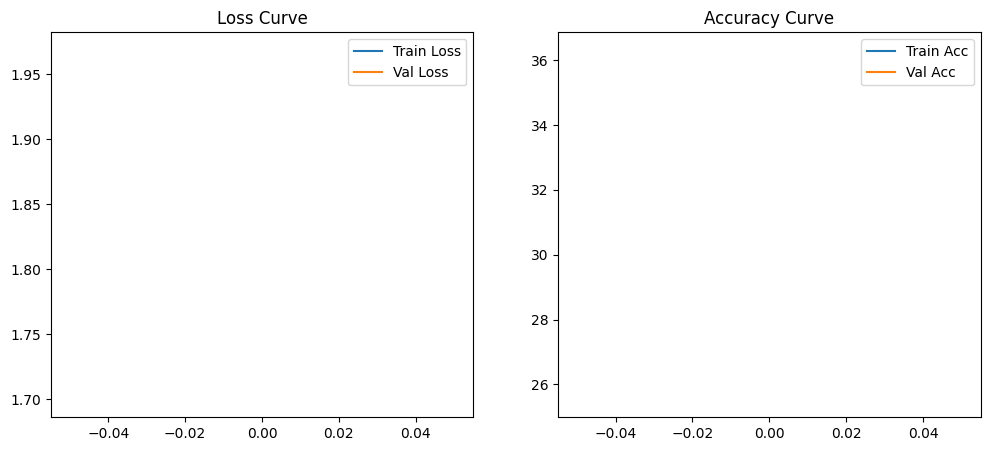

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
